#### Gaussian process regression simulation

The simulation will include slop which was estimated from the first bayes model. 
In addition a dummy distance map will be generated for each row. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import pandas as pd

import seaborn as sns
# from PIL import fromarray
from skimage.filters import threshold_local
from scipy.ndimage.morphology import binary_opening
from skimage import io, filters, measure, color, img_as_ubyte
import skimage.morphology as sm
from skimage.segmentation import watershed
from skimage import measure, restoration,morphology
from skimage.exposure import rescale_intensity
import os
import pandas as pd
from scipy.ndimage.morphology import binary_fill_holes
import re
import glob
import random
import plotnine
from sklearn import preprocessing

RANDOM_SEED = 8927
np.random.seed(286)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Simulate K gaussian  output
$etasq^2 \times e^{-\frac{x^2}{ls^2}}$
#### Finding the covariant matrix priors rho and eta. 


In [4]:
def cal_y(a,b,c,opr):
    return a + b*np.exp(-b*opr)

In [14]:
opr_arr_uniqe


array([1, 2, 3, 4])

In [46]:
id_arr_uniqe = np.array((0,1,2,3,4,5))
Nid = len(id_arr_uniqe)
id_arr = np.repeat(np.arange(6),4)
opr_arr_uniqe = np.linspace(1,4,4,dtype=int,endpoint=True)
Nopr = len(opr_arr_uniqe)
opr_arr = np.array(list(np.arange(0,4))*6)

x = np.array((-0.5,-.8,-.10,.7,.9,.8))
a = np.random.normal(0.05,0.1,6) * x
b = np.random.exponential(0.3,6) * x
c = np.random.normal(0.05,0.01,6) * x 
cal_y(np.repeat(a,4),np.repeat(b,4),np.repeat(c,4),opr_arr+1)
print('{}'.format(a))
print('{}'.format(b))
print('{}'.format(c))

[-0.00460538 -0.0589101   0.00607691  0.00516087  0.00221964  0.15227512]
[-0.16158881 -0.29949198 -0.08831684  0.29610922  0.19255821  0.39064762]
[-0.02322921 -0.03103199 -0.00617912  0.04851407  0.04561747  0.04774005]


In [5]:
id_arr_uniqe = np.array((0,1,2,3,4,5))
Nid = len(id_arr_uniqe)
id_arr = np.repeat(np.arange(6),4)
opr_arr_uniqe = np.linspace(1,4,4,dtype=int,endpoint=True)
Nopr = len(opr_arr_uniqe)
opr_arr = np.array(list(np.arange(0,4))*6)

x = np.array((-0.5,-.8,-.10,.7,.9,.8))
a = np.random.normal(0.05,0.1,6) * x
b = np.random.exponential(0.3,6) * x
c = np.random.normal(0.05,0.01,6) * x 
y = cal_y(np.repeat(a,4),np.repeat(b,4),np.repeat(c,4),opr_arr+1)

p = np.array((0,0,0,1,1,1))
Dmat = np.array([[0,1,2,8,3,7],
                 [1,0,3,9,4,7],
                 [2,2,0,5,3,4],
                 [8,9,5,0,2,1],
                 [3,4,3,2,0,2],
                 [7,7,4,1,2,0]])
Dmatsq = Dmat**2
Dmatsq = Dmatsq +1
Dmatsq

array([[ 1,  2,  5, 65, 10, 50],
       [ 2,  1, 10, 82, 17, 50],
       [ 5,  5,  1, 26, 10, 17],
       [65, 82, 26,  1,  5,  2],
       [10, 17, 10,  5,  1,  5],
       [50, 50, 17,  2,  5,  1]], dtype=int32)

## **Priors prediction analysis:**
#### Etasq^2 = the maximum covariance between any two points
#### Ls_inv = rate of decline, if it is big then the exponante will be closer to zero and covariance is smaller

In [9]:
with pm.Model() as model_:
    etasq = pm.Exponential("etasq",0.5)
    ls_inv = pm.Exponential("ls_inv",1)
    cov = etasq**2*pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    K = gp.prior("k", X=Dmatsq)
    
    mu = K[id_arr]  # linear model
    sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within image
    signal = pm.Normal("signal", mu=mu, sigma=sigma_within, observed=y)  # likelihood
    trace = pm.sample(4000, tune=4000,cores=1 ,random_seed=RANDOM_SEED,target_accept=0.9,)  # Make sure not to draw too many sampl

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_within, k_rotated_, ls_inv, etasq]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 55 seconds.
There were 288 divergences after tuning. Increase `target_accept` or reparameterize.
There were 329 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


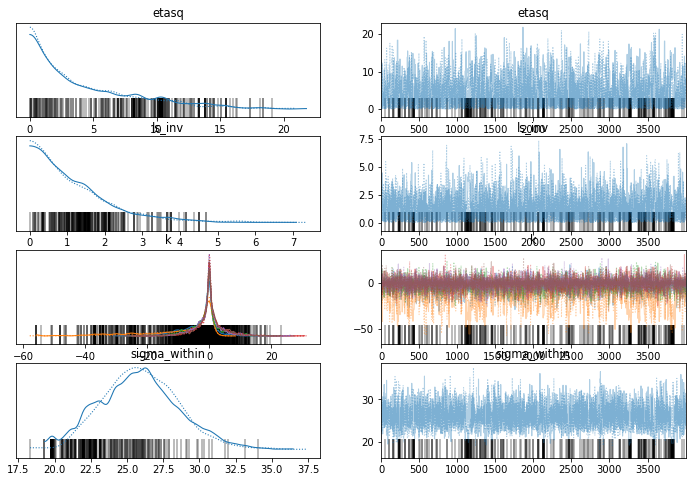

In [11]:
with model_:
    idata = az.from_pymc3(trace, dims={"k": ["id_arr"]})
az.plot_trace(idata, var_names=["~k_rotated_"], compact=True);   

In [33]:
# adding virabalies
with pm.Model() as model_:
    
    a = pm.Normal('a',0.05,1,shape= Nid)
    b = pm.Exponential('b',1,shape= Nid)
    c = pm.Normal('c',0.5,1,shape= Nid)
    
    etasq = pm.Exponential("etasq",2)
    ls_inv = pm.Exponential("ls_inv",4)
    cov = etasq**2*pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    K = gp.prior("k", X=Dmatsq)
    
    mu = a[id_arr] + c[id_arr]*tt.exp(-b[id_arr]*opr_arr) + K[id_arr]  # linear model
    
    sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within image
    signal = pm.Normal("signal", mu=mu, sigma=sigma_within, observed=y)  # likelihood
    trace = pm.sample(4000, tune=4000,cores=1 ,random_seed=RANDOM_SEED,target_accept=0.9,)  # Make sure not to draw too many sampl

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\pymc3\gp\cov.py:97: UserWarning: Only 1 column(s) out of 6 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_within, k_rotated_, ls_inv, etasq, c, b, a]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 78 seconds.


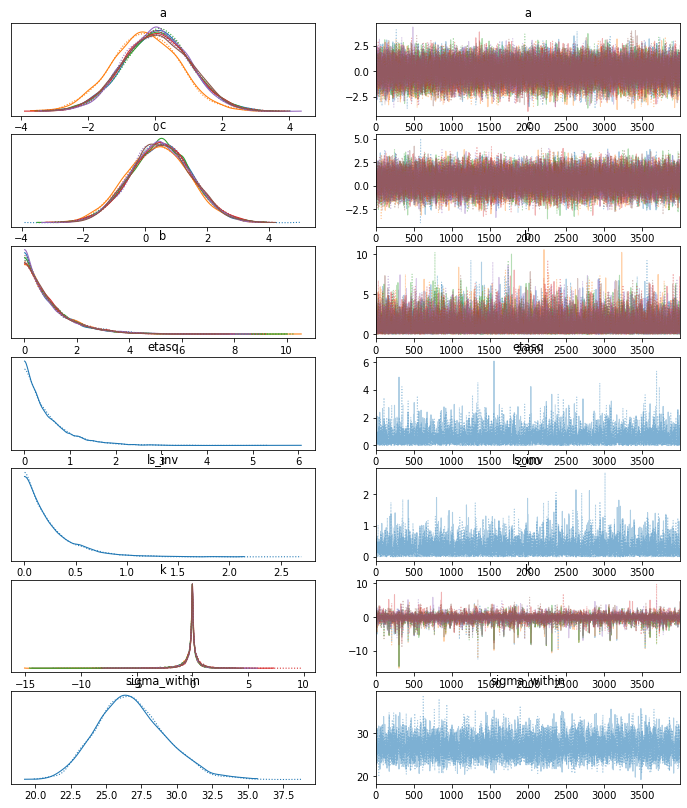

In [34]:
with model_:
    idata = az.from_pymc3(trace, dims={"k": ["id_arr"]})
az.plot_trace(idata, var_names=["~k_rotated_"], compact=True);   

In [35]:
az.summary(idata, var_names=["~k_rotated_"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.04,1.00,-1.88,1.85,0.01,0.01,7494.17,5856.91,1.0
a[1],-0.30,1.00,-2.22,1.55,0.01,0.01,9380.92,6354.43,1.0
a[2],0.06,1.00,-1.88,1.88,0.01,0.01,12277.23,6106.26,1.0
a[3],0.04,1.00,-1.74,2.01,0.01,0.01,9972.83,5256.03,1.0
a[4],0.04,0.97,-1.86,1.79,0.01,0.01,11849.37,6505.62,1.0
a[5],0.04,1.01,-1.77,1.97,0.01,0.01,9492.57,5608.36,1.0
c[0],0.50,1.00,-1.40,2.32,0.01,0.01,12573.33,6073.87,1.0
c[1],0.40,1.01,-1.43,2.39,0.01,0.01,8715.06,6084.51,1.0
c[2],0.49,1.00,-1.39,2.38,0.01,0.01,8803.57,6766.54,1.0
c[3],0.52,1.01,-1.36,2.44,0.01,0.01,9293.14,6018.78,1.0


In [40]:
# adding virabalies and multilevel
with pm.Model() as model_:
    
    a_bar = pm.Normal("a_bar", 0.05,3)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    a = pm.Normal("a", a_bar, sigma_a,shape= Nid)
    
    b = pm.Exponential('b',1,shape= Nid)
    
    c_bar = pm.Normal("c_bar", 0.5,3)
    sigma_c = pm.Exponential("sigma_c",1)
    c = pm.Normal('c',0.5,1,shape= Nid)
    
    etasq = pm.Exponential("etasq",2)
    ls_inv = pm.Exponential("ls_inv",0.4)
    cov = etasq**2*pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    K = gp.prior("k", X=Dmatsq)
    
    mu = a[id_arr] + c[id_arr]*tt.exp(-b[id_arr]*opr_arr) + K[id_arr]  # linear model
    
    sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within image
    signal = pm.Normal("signal", mu=mu, sigma=sigma_within, observed=y)  # likelihood
    trace = pm.sample(4000, tune=8000,cores=1 ,random_seed=RANDOM_SEED,target_accept=0.9,) 

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\pymc3\gp\cov.py:97: UserWarning: Only 1 column(s) out of 6 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_within, k_rotated_, ls_inv, etasq, c, sigma_c, c_bar, b, a, sigma_a, a_bar]


Sampling 2 chains for 8_000 tune and 4_000 draw iterations (16_000 + 8_000 draws total) took 406 seconds.
There were 405 divergences after tuning. Increase `target_accept` or reparameterize.
There were 792 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.83717580611486, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


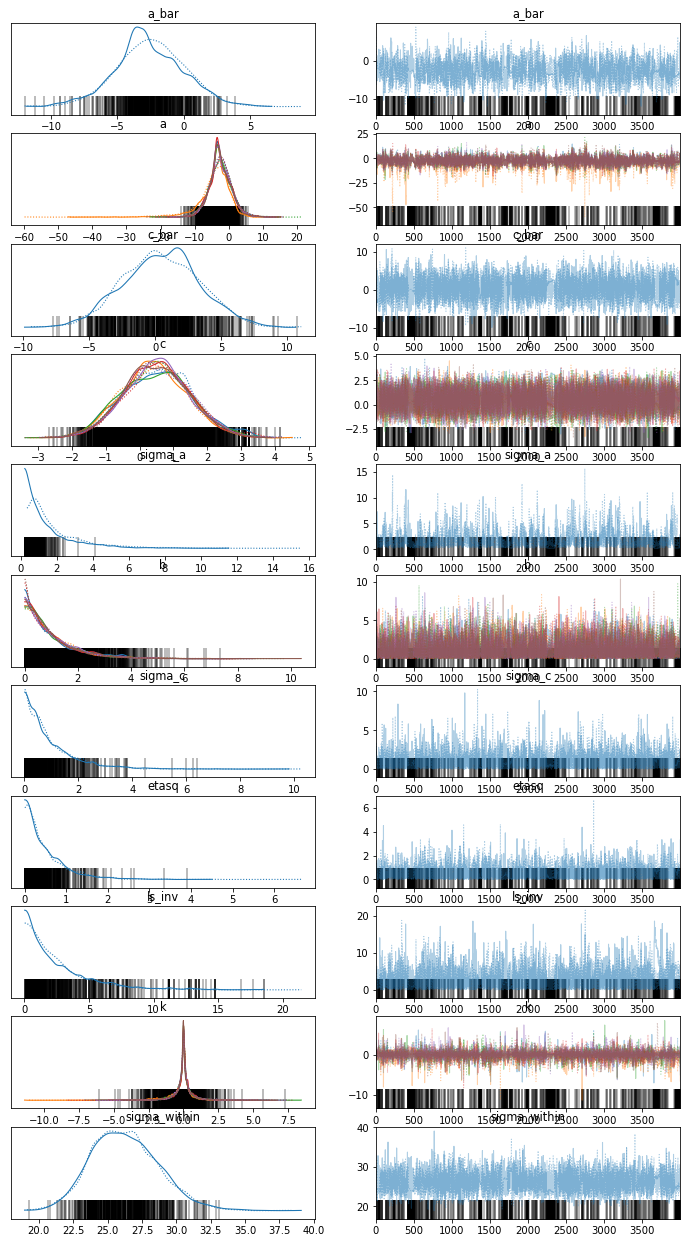

In [41]:
with model_:
    idata = az.from_pymc3(trace, dims={"k": ["id_arr"]})
az.plot_trace(idata, var_names=["~k_rotated_"], compact=True);  

In [42]:
az.summary(idata, var_names=["~k_rotated_"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-2.54,2.61,-7.42,2.48,0.07,0.05,1439.89,2323.62,1.00
a[0],-2.48,3.34,-9.23,3.42,0.08,0.05,1826.64,2900.80,1.00
a[1],-4.30,4.81,-13.12,3.44,0.14,0.10,1290.31,1805.41,1.01
a[2],-2.45,3.45,-8.96,4.10,0.08,0.06,1812.86,2581.18,1.00
a[3],-2.41,3.34,-8.96,3.66,0.08,0.05,1812.17,2832.96,1.00
a[4],-2.47,3.28,-8.63,3.71,0.07,0.05,1877.11,2729.45,1.00
a[5],-2.48,3.34,-8.91,3.65,0.07,0.05,1920.64,2705.22,1.00
c_bar,0.47,2.93,-4.85,5.96,0.06,0.05,2140.68,3264.68,1.00
c[0],0.52,1.04,-1.54,2.35,0.04,0.04,653.98,288.54,1.00
c[1],0.42,0.98,-1.41,2.26,0.02,0.01,3067.31,3938.34,1.00


In [44]:
np.linspace(0., 1., 2500)

array([0.00000000e+00, 4.00160064e-04, 8.00320128e-04, ...,
       9.99199680e-01, 9.99599840e-01, 1.00000000e+00])

[Text(0.5, 1.0, 'Gaussian process posterior'),
 (-0.1, 5.0),
 Text(0.5, 0, 'distance (thousand km)'),
 Text(0, 0.5, 'covariance')]

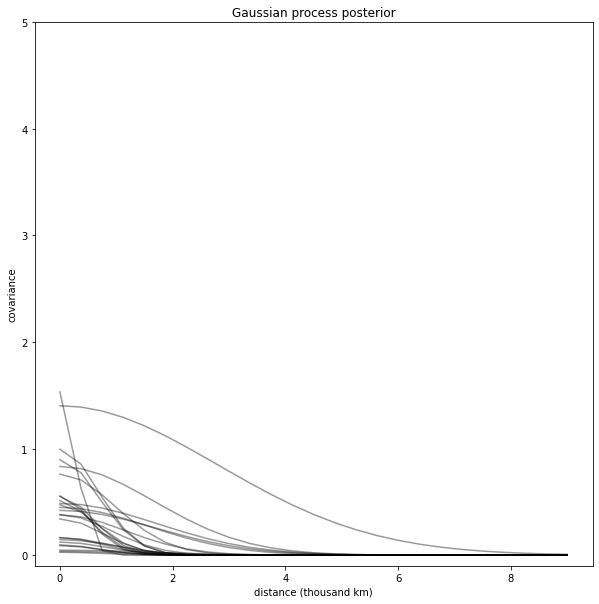

In [107]:
n = 25
distance_sqr = np.linspace(0,9,n) 
etasq = np.random.exponential(0.5,n)
ls_inv = np.random.exponential(1,n)
cov = a**2*np.exp(-distance_sqr**2*b**2)
_, ax = plt.subplots(1, 1, figsize=(10, 10))
for a, b  in zip(etasq, ls_inv):
    ax.plot(distance_sqr,a*np.exp(-distance_sqr**2*b), "k", alpha=0.4)
ax.set(
        title="Gaussian process posterior",
        ylim=(-0.1, 5),
        xlabel="distance (thousand km)",ylabel="covariance")


In [102]:
import theano
with pm.Model() as model:
    etasq = pm.Exponential("etasq",0.5)
    ls_inv = pm.Exponential("ls_inv",1)
    cov = etasq**2*pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    K = gp.prior("k", X=Dmatsq)
    
    p = pm.Deterministic("p", pm.invlogit(tt.exp(K*x)))
    prob = pm.Binomial("prob", 1, p, observed=y)
    
    step = pm.Metropolis()
    trace = pm.sample(
            4000, step, progressbar=True
        )  # Make sure not to draw too many sampl

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\pymc3\gp\cov.py:97: UserWarning: Only 1 column(s) out of 6 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [k_rotated_]
>Metropolis: [ls_inv]
>Metropolis: [etasq]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 48 seconds.
The number of effective samples is smaller than 10% for some parameters.


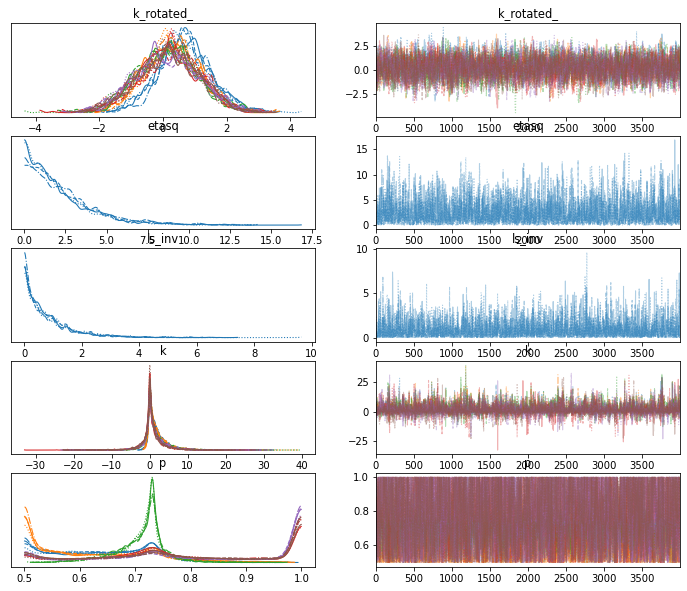

In [103]:
with pm.Model() as model:
    idata = az.from_pymc3(trace)
az.plot_trace(idata);

In [108]:
az.summary(trace, round_to=2)

Got error No model on context stack. trying to find log_likelihood in translation.
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_rotated_[0],0.66,0.87,-0.95,2.36,0.03,0.02,845.65,1334.02,1.00
k_rotated_[1],0.29,0.90,-1.41,1.97,0.03,0.02,926.73,1189.58,1.00
k_rotated_[2],0.13,0.97,-1.68,1.93,0.03,0.02,769.39,1243.36,1.01
k_rotated_[3],0.19,0.98,-1.64,2.03,0.04,0.03,731.57,1276.71,1.00
k_rotated_[4],0.13,1.02,-1.71,2.06,0.04,0.03,720.42,1222.74,1.00
k_rotated_[5],0.19,0.97,-1.65,1.97,0.03,0.02,896.91,1298.00,1.00
etasq,2.25,2.06,0.00,5.95,0.04,0.03,1647.72,2027.33,1.00
ls_inv,0.84,0.91,0.00,2.47,0.02,0.01,2323.47,2695.83,1.00
k[0],1.84,2.84,-1.62,6.94,0.07,0.05,1079.29,2406.80,1.01
k[1],1.95,2.88,-1.27,7.09,0.07,0.05,1365.14,3404.94,1.00


In [109]:
trace_df = pm.trace_to_dataframe(trace)
trace_df

,k_rotated___0,k_rotated___1,k_rotated___2,k_rotated___3,k_rotated___4,k_rotated___5,etasq,ls_inv,k__0,k__1,k__2,k__3,k__4,k__5,p__0,p__1,p__2,p__3,p__4,p__5
0,-0.799593,-1.566385,-0.020009,-0.779324,-0.021935,0.594824,0.151645,0.201320,-0.121257,-0.166210,-0.237079,-0.118183,-0.126928,0.088962,0.743169,0.758086,0.735749,0.715165,0.709313,0.745312
1,-0.799593,-1.566385,-0.020009,-0.779324,-0.021935,0.594824,0.426173,0.263326,-0.340766,-0.501946,-0.656742,-0.332128,-0.163011,0.253363,0.765982,0.816700,0.744193,0.688380,0.703401,0.772888
2,-0.799593,-1.566385,-0.020009,-0.779324,-0.021935,0.594824,0.426173,0.009077,-0.340766,-0.347202,-0.363770,-0.666263,-0.392555,-0.602184,0.765982,0.789210,0.738280,0.651869,0.668712,0.649696
3,-0.799593,-1.566385,-0.020009,-0.779324,-0.021935,0.594824,0.426173,0.010398,-0.340766,-0.348032,-0.367338,-0.700859,-0.400524,-0.634997,0.765982,0.789356,0.738351,0.648456,0.667599,0.646045
4,0.149895,-1.638179,-1.575323,-0.020608,0.284509,1.178030,0.426173,0.010398,0.063881,0.056257,0.028134,-0.425386,-0.015850,-0.331923,0.724833,0.722319,0.730506,0.677536,0.728265,0.682827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,2.406420,-0.066302,-0.369503,-0.580956,1.426245,-0.088946,9.117088,0.022702,21.939544,21.920170,21.779735,2.487813,21.297808,8.679913,0.500004,0.500000,0.528287,0.996684,1.000000,1.000000
15996,1.367375,-0.601109,-0.346245,-0.539113,1.008472,-0.251362,2.840902,0.002021,3.884579,3.881016,3.869227,3.589802,3.851010,3.669155,0.535783,0.511206,0.663548,0.999996,1.000000,1.000000
15997,1.367375,-0.601109,-0.346245,-0.539113,1.008472,-0.251362,2.840902,0.002021,3.884579,3.881016,3.869227,3.589802,3.851010,3.669155,0.535783,0.511206,0.663548,0.999996,1.000000,1.000000
15998,1.367375,-0.601109,-0.346245,-0.539113,1.008472,-0.251362,2.840902,0.007833,3.884579,3.871056,3.827433,2.375708,3.750389,2.827228,0.535783,0.511296,0.664182,0.994909,1.000000,0.999932


[Text(0.5, 1.0, 'Gaussian process posterior'),
 (-0.1, 10.0),
 Text(0.5, 0, 'distance (thousand km)'),
 Text(0, 0.5, 'covariance')]

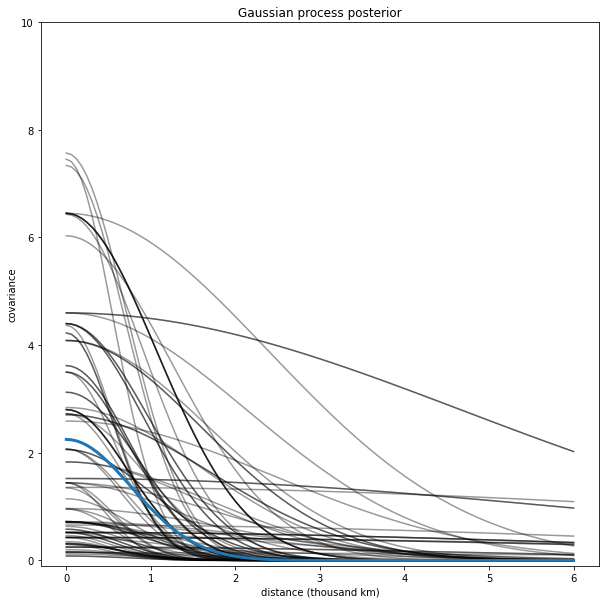

In [130]:
distance_sqr = np.linspace(0, 6, 100)
pmcov_mu = np.mean(trace_df.etasq) * np.exp(-np.mean(trace_df.ls_inv) *(x_seq**2))
_, ax = plt.subplots(1, 1, figsize=(10, 10))
etasq = trace_df.etasq.values[:100]
ls_inv = trace_df.ls_inv.values[:100]
cnt = 0
for a, b  in zip(etasq, ls_inv):
    ax.plot(distance_sqr,a*np.exp(-distance_sqr**2*b), "k", alpha=0.4)
ax.plot(distance_sqr, pmcov_mu, lw=3)       
ax.set(
        title="Gaussian process posterior",
        ylim=(-0.1, 10),
        xlabel="distance (thousand km)",ylabel="covariance")

In [24]:
x = np.linspace(1,10,10)
a = np.array([-.01,-.2,-.0001,.4,0.05,0.2])
b = np.round(np.random.normal(0,0.1,6),3)
b

array([-0.041, -0.055, -0.169, -0.073, -0.028,  0.102])

In [8]:
#y = a*x + b
# data array
# rows sequnce (10 raws)
# column observation (6 cloumn)
col_n = 6
row_n = 10
data_ar = np.zeros((10,6))
for row in range(row_n):
    for col in range(col_n):
       data_ar[row,col] = a[col]*x[row] + b[col]
data_ar

array([[-0.051 , -0.255 , -0.1691,  0.327 ,  0.022 ,  0.302 ],
       [-0.061 , -0.455 , -0.1692,  0.727 ,  0.072 ,  0.502 ],
       [-0.071 , -0.655 , -0.1693,  1.127 ,  0.122 ,  0.702 ],
       [-0.081 , -0.855 , -0.1694,  1.527 ,  0.172 ,  0.902 ],
       [-0.091 , -1.055 , -0.1695,  1.927 ,  0.222 ,  1.102 ],
       [-0.101 , -1.255 , -0.1696,  2.327 ,  0.272 ,  1.302 ],
       [-0.111 , -1.455 , -0.1697,  2.727 ,  0.322 ,  1.502 ],
       [-0.121 , -1.655 , -0.1698,  3.127 ,  0.372 ,  1.702 ],
       [-0.131 , -1.855 , -0.1699,  3.527 ,  0.422 ,  1.902 ],
       [-0.141 , -2.055 , -0.17  ,  3.927 ,  0.472 ,  2.102 ]])

In [9]:
df = pd.DataFrame({'rd':x.tolist(),'ph_1':data_ar[:,0],'ph_2':data_ar[:,1],'ph_3':data_ar[:,2],
                  'norm_1':data_ar[:,3],'norm_2':data_ar[:,4],'norm_3':data_ar[:,5]})
df = pd.melt(df, id_vars='rd', value_vars=['ph_1', 'ph_2','ph_3','norm_1','norm_2','norm_3'])
df.rename({'variable': 'image_group', 'value': 'signal'}, axis=1, inplace=True)
df

,rd,image_group,signal
0,1.0,ph_1,-0.0510
1,2.0,ph_1,-0.0610
2,3.0,ph_1,-0.0710
3,4.0,ph_1,-0.0810
4,5.0,ph_1,-0.0910
5,6.0,ph_1,-0.1010
6,7.0,ph_1,-0.1110
7,8.0,ph_1,-0.1210
8,9.0,ph_1,-0.1310
9,10.0,ph_1,-0.1410


F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.


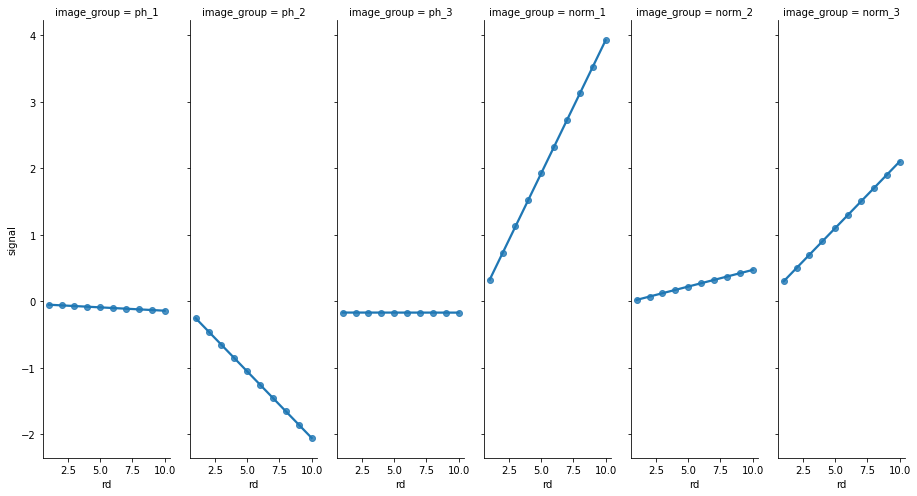

In [11]:
sns.lmplot(x="rd", y="signal", col="image_group", data=df, col_wrap=9, palette="muted", aspect=0.3, size=7)

In [12]:
Dmat = np.array([[0,1,2,8,3,7],
                 [1,0,3,9,4,7],
                 [2,2,0,5,3,4],
                 [8,9,5,0,2,1],
                 [3,4,3,2,0,2],
                 [7,7,4,1,2,0]])

In [6]:
df = pd.DataFrame({'slope':slope,'prob':prob,'id':id_})
df.sort_values('id')

,slope,prob,id
1,-0.50,0.99000,1
3,0.10,0.21000,2
0,-0.20,0.75000,3
2,-0.30,0.85000,4
5,0.01,0.45000,5
4,0.80,0.00001,6


In [6]:
with pm.Model() as test:
    etasq = pm.Exponential("etasq", 2.0)
    ls_inv = pm.HalfNormal("ls_inv", 2.0)
    rhosq = pm.Deterministic("rhosq", 0.5 * ls_inv**2)
    step = pm.Metropolis()
    trace = pm.sample(1, step)

#post["etasq"].median().values * np.exp(-post["rhosq"].median().values * (x_seq**2))

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Only 1 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [ls_inv]
>Metropolis: [etasq]


Sampling 4 chains for 1_000 tune and 1 draw iterations (4_000 + 4 draws total) took 36 seconds.
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\arviz\data\base.py:225: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\pymc3\sampling.py:659: UserWarning: The number of samples is too small to check convergence reliably.


In [7]:
x = np.linspace(0,8,8)
rhosq = np.array(trace["rhosq"])
etasq = np.array(trace["etasq"])
np.median(rhosq) * np.exp(-np.median(etasq) * x**2)

array([2.53102004e+00, 1.35530782e+00, 2.08096617e-01, 9.16171580e-03,
       1.15657375e-04, 4.18653341e-07, 4.34530747e-10, 1.29321633e-13])

In [7]:
Dmatsq = np.power(Dmat, 2)
Dmatsq
#K = post["etasq"].median().values * np.exp(-post["rhosq"].median().values * Dmatsq) + np.diag([0.01] * Nsociety)
#np.median(rhosq) * np.exp(-np.median(etasq) * Dmatsq) + np.diag([0.01] * 6)
# kk = np.median(rhosq) * np.exp(-np.median(etasq) * Dmatsq) + np.diag([0.01] * 6)
# np.round(kk,1)

array([[ 0, 36,  1,  1,  9, 64],
       [36,  0,  9, 16,  1,  4],
       [ 1,  9,  0,  1,  4, 25],
       [ 1, 16,  1,  0,  9, 16],
       [ 9,  1,  4,  9,  0,  4],
       [64,  4, 25, 16,  4,  0]], dtype=int32)

In [2]:
x = np.array((0.06,.01,.02,.7,.9,.8))
y = np.array((2,2,2,1,1,1))
Dmat = np.array([[0,1,2,8,3,7],
                 [1,0,3,9,4,7],
                 [2,2,0,5,3,4],
                 [8,9,5,0,2,1],
                 [3,4,3,2,0,2],
                 [7,7,4,1,2,0]])

### Simulate K gaussian  output

$etasq^2 \times e^{-\frac{x^2}{ls^2}}$

In [52]:
etasq = 1
ls_inv = 0.5
lm = etasq**2*np.exp2(x**2*ls_inv)
np.exp(lm) / (1 + np.exp(lm))
Dmat * lm

array([[ 0.        ,  1.00003466,  2.00027728,  9.48074217,  3.97226673,
         8.73831384],
       [ 1.00124844,  0.        ,  3.00041592, 10.66583494,  5.29635564,
         8.73831384],
       [ 2.00249689,  2.00006932,  0.        ,  5.92546385,  3.97226673,
         4.9933222 ],
       [ 8.00998755,  9.00031192,  5.0006932 ,  0.        ,  2.64817782,
         1.24833055],
       [ 3.00374533,  4.00013863,  3.00041592,  2.37018554,  0.        ,
         2.4966611 ],
       [ 7.00873911,  7.00024261,  4.00055456,  1.18509277,  2.64817782,
         0.        ]])

In [13]:
import theano
with pm.Model() as model:
    etasq = 1
    ls_inv = 0.5
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=0.5)
K = theano.function([], cov(Dmat))()


array([[1.00000000e+00, 8.82496903e-01, 6.06530660e-01, 3.35462628e-04,
        3.24652467e-01, 2.18749112e-03],
       [8.82496903e-01, 1.00000000e+00, 8.82496903e-01, 2.18749112e-03,
        6.06530660e-01, 1.11089965e-02],
       [6.06530660e-01, 8.82496903e-01, 1.00000000e+00, 1.11089965e-02,
        8.82496903e-01, 4.39369336e-02],
       [3.35462628e-04, 2.18749112e-03, 1.11089965e-02, 1.00000000e+00,
        4.39369336e-02, 8.82496903e-01],
       [3.24652467e-01, 6.06530660e-01, 8.82496903e-01, 4.39369336e-02,
        1.00000000e+00, 1.35335283e-01],
       [2.18749112e-03, 1.11089965e-02, 4.39369336e-02, 8.82496903e-01,
        1.35335283e-01, 1.00000000e+00]])

In [50]:
with pm.Model() as gauess_sim_test:
    # hyper-priors
    # Implementation with PyMC's GP module:
    cov = 1 * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=0.5)
    gp = pm.gp.Latent(cov_func=cov)
    k = gp.prior("k", X=Dmat)
    step = pm.Metropolis()
    trace = pm.sample(
        1, step, progressbar=True
    )  # Make sure not to draw too many samples

Only 3 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [k_rotated_]


Sampling 4 chains for 1_000 tune and 3 draw iterations (4_000 + 12 draws total) took 44 seconds.
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\arviz\data\base.py:225: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\pymc3\sampling.py:659: UserWarning: The number of samples is too small to check convergence reliably.


array([[-1.07227289, -1.33063739, -1.59776732,  1.77410674, -1.59857899,
         0.8392199 ],
       [-0.37350159, -0.38066197, -0.70630021,  0.71859065, -1.03074578,
        -0.22250396],
       [-0.37350159, -0.38066197, -0.70630021,  0.71859065, -1.03074578,
        -0.22250396],
       [ 0.1546665 , -0.1825695 , -0.57513423,  1.81126155, -1.04360988,
         0.83706876],
       [-0.42472549, -0.34528773, -0.15770561, -0.77642634, -0.5433036 ,
        -1.25475994],
       [-0.18812801, -0.16593919,  0.042869  ,  0.33148311, -0.07422992,
         0.25160993],
       [-1.07553125, -0.26996324,  0.27836728, -0.56954264,  0.18906154,
        -1.32716033],
       [ 1.19809352,  1.63206329,  1.80755346, -0.07253773,  1.55454249,
        -0.5395438 ],
       [ 1.19809352,  1.63206329,  1.80755346, -0.07253773,  1.55454249,
        -0.5395438 ],
       [-0.79573418, -0.70610885, -0.78145401, -1.3731843 , -0.62585663,
        -0.51102898],
       [-0.79573418, -0.70610885, -0.78145401, -1.

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(10, 10))
slopes = np.random.normal(0, 3, 100)
for b ,c in zip(slopes, prexcentage_loss):
    lm = c**(-b*open_operation)
    ax.plot(open_operation, np.exp(lm) / (1 + np.exp(lm)), "k", alpha=0.4)
    ax.set_xlabel("opning operation")
    ax.set_ylabel("probability");
plt.tight_layout();

In [40]:
with pm.Model() as gauess_sim_test:
    # hyper-priors
    b = pm.HalfNormal("b", 0.00001)
    etasq = pm.Exponential("etasq", 10)
    ls_inv = pm.HalfNormal("ls_inv", 1)
    rhosq = pm.Deterministic("rhosq", 0.5 * ls_inv**2)

    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    k = gp.prior("k", X=Dmat)
    trace = pm.sample(
        1, step, progressbar=True
    )  # Make sure not to draw too many samples

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\pymc3\gp\cov.py:97: UserWarning: Only 1 column(s) out of 6 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Only 1 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [k_rotated_]
>>Metropolis: [ls_inv]
>>Metropolis: [etasq]
>>Metropolis: [b]
>NUTS: [k_rotated_, ls_inv, etasq, b]


Sampling 4 chains for 1_000 tune and 1 draw iterations (4_000 + 4 draws total) took 43 seconds.
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\arviz\data\base.py:225: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\pymc3\sampling.py:659: UserWarning: The number of samples is too small to check convergence reliably.


In [41]:
trace['k']

array([[-0.09518734, -0.11225287, -0.12275117,  0.12095791, -0.11924161,
         0.04795217],
       [ 0.06714413,  0.10010541,  0.31744086,  0.28493264,  0.003346  ,
         0.03194033],
       [-0.2204626 ,  0.36732997,  0.01934972, -0.04613566,  0.07903723,
        -0.53436291],
       [-0.38782941,  0.58990842,  0.84002225, -0.13265786,  0.42551068,
         0.48741976]])

In [29]:
xtemp = np.ones((12,6))
x*xtemp*trace['k']

array([[ 0.21261374,  0.19145997,  0.05073098,  0.47009098,  0.21731663,
         0.57465784],
       [-0.32867526, -0.15787509, -0.15802189, -0.6300339 , -0.90667485,
        -0.71054019],
       [ 0.16433711,  0.26200183, -0.026273  ,  0.2377943 , -0.25800607,
         0.10100687],
       [-0.10048825, -0.04871789,  0.01743441,  0.23021417,  0.09738315,
         0.25165597],
       [-0.86610518, -0.15373867, -0.27319644,  0.77331032, -0.74256246,
         0.59746999],
       [-0.86610518, -0.15373867, -0.27319644,  0.77331032, -0.74256246,
         0.59746999],
       [ 0.7698443 ,  0.89632441,  0.8243672 , -0.83386889,  0.56125764,
        -0.51852078],
       [-0.09946011, -0.10462306, -0.01106786,  0.27827543, -0.03969239,
         0.08133177],
       [ 0.22487037,  0.37233146,  0.32035575, -0.25367419,  0.22040521,
        -0.00707788],
       [ 0.22227951,  0.22000015,  0.22111021,  0.23978412,  0.2207788 ,
         0.23554072],
       [ 0.02149647, -0.1001013 , -0.19915525,  0.

In [28]:
trace_df = pm.trace_to_dataframe(trace)
trace_df

,k_rotated___0,k_rotated___1,k_rotated___2,k_rotated___3,k_rotated___4,k_rotated___5,b,etasq,ls_inv,rhosq,k__0,k__1,k__2,k__3,k__4,k__5
0,0.783186,0.118478,-0.564028,1.732283,2.781863,0.929918,0.000002,0.073697,0.644841,0.207910,0.212614,0.191460,0.050731,0.470091,0.217317,0.574658
1,-0.912448,-0.027238,-0.443480,-1.749061,-2.644436,-1.322958,0.000002,0.129752,1.257165,0.790232,-0.328675,-0.157875,-0.158022,-0.630034,-0.906675,-0.710540
2,0.730852,0.911282,-0.972767,1.057537,-0.848267,-0.184723,0.000004,0.050560,1.062630,0.564591,0.164337,0.262002,-0.026273,0.237794,-0.258006,0.101007
3,-0.548734,1.000269,0.827749,0.759796,1.483612,-1.120006,0.000003,0.033535,0.267902,0.035886,-0.100488,-0.048718,0.017434,0.230214,0.097383,0.251656
4,-1.974284,-0.097509,-0.614760,1.762758,-1.626695,1.144866,0.000017,0.192451,2.025646,2.051620,-0.866105,-0.153739,-0.273196,0.773310,-0.742562,0.597470
5,-1.974284,-0.097509,-0.614760,1.762758,-1.626695,1.144866,0.000017,0.192451,2.025646,2.051620,-0.866105,-0.153739,-0.273196,0.773310,-0.742562,0.597470
6,1.701146,1.027766,-0.044568,-1.852935,-0.164380,1.336815,0.000007,0.204796,0.468776,0.109875,0.769844,0.896324,0.824367,-0.833869,0.561258,-0.518521
7,-0.779282,-0.481036,0.305355,2.180323,-0.549827,-0.603649,0.000008,0.016289,1.130981,0.639559,-0.099460,-0.104623,-0.011068,0.278275,-0.039692,0.081332
8,0.844591,1.133904,0.226035,-0.952777,0.462545,0.915963,0.000003,0.070887,0.829244,0.343823,0.224870,0.372331,0.320356,-0.253674,0.220405,-0.007078
9,0.625671,-0.150575,1.443464,1.263199,-0.745558,1.060855,0.000005,0.126213,0.039199,0.000768,0.222280,0.220000,0.221110,0.239784,0.220779,0.235541


In [ ]:
_, ax = plt.subplots(1, 1, figsize=(10, 10))
slopes = np.random.normal(0, 3, 100)
for b ,c in zip(slopes, prexcentage_loss):
    lm = 
    ax.plot(open_operation, np.exp(lm) / (1 + np.exp(lm)), "k", alpha=0.4)
    ax.set_xlabel("opning operation")
    ax.set_ylabel("probability");
plt.tight_layout();

In [21]:
with pm.Model() as gauess_sim_test:
    # hyper-priors
    b = pm.HalfNormal("b", 0.00001)
    etasq = pm.Exponential("etasq", 10)
    ls_inv = pm.HalfNormal("ls_inv", 1)
    rhosq = pm.Deterministic("rhosq", 0.5 * ls_inv**2)

    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    k = gp.prior("k", X=Dmat)
    
    p = pm.Deterministic("p", pm.invlogit(tt.exp(k*x)))
    prob = pm.Binomial("prob", 1, p, observed=y)
    step = pm.Metropolis()
    trace = pm.sample(
        3, step, progressbar=True
    )  # Make sure not to draw too many samples

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\pymc3\gp\cov.py:97: UserWarning: Only 1 column(s) out of 6 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'b_log__': array(-11.73871682), 'etasq_log__': array(-2.66909801), 'ls_inv_log__': array(-0.22579135), 'k_rotated_': array([0., 0., 0., 0., 0., 0.])}

Initial evaluation results:
b_log__        -0.77
etasq_log__    -1.06
ls_inv_log__   -0.77
k_rotated_     -5.51
prob            -inf
Name: Log-probability of test_point, dtype: float64

## Prior Prediction

Function for inverslogit:

In [8]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

The covarince matrix is define by: 

$$
K(ij) = rhosq * np.exp(-sigma*Dmatsq(ij))
$$

Optional: 
$$
K(ij) = rhosq * np.exp(-sigma*Dmatsq(ij)) + np.diag([0.01]) * 6
$$

slopes and p value are calculated from the classification model


-[x] Predict parameters for calculate the covariant

-[ ] Predict parameters for calculate the probability 

In [9]:
slope = np.array((-0.2,-0.5,-0.3,0.1,0.8,0.01))
prob = np.array((0.75,0.99,0.85,0.21,0.00001,0.45))
id_ = np.array((3,1,4,2,6,5))

Dmat = np.array([[0,6,1,1,3,8],
                 [6,0,3,4,1,2],
                 [1,3,0,1,2,5],
                 [1,4,1,0,3,4],
                 [3,1,2,3,0,2],
                 [8,2,5,4,2,0]])

#Paramters:
rhosq = np.random.exponential(0.5)
sigma = np.random.exponential(0.5)
b  = np.random.normal(0.5,2)
x = slope

def gp_k(rhosq,sigma,mat):
    return rhosq * np.exp(-sigma*mat)

def prob_estamet(s,k,b):
    return inv_logit(s**k*b)

In [15]:
# k1
rhosq = 1
sigma = 1
k = []
for i in range(6):
    mat = Dmat[0,i]
    k.append(gp_k(rhosq,sigma,mat))

In [21]:
k = []
for i in range(6):
    mat = Dmat[0,i]
    k.append(gp_k(rhosq,sigma,mat))
k1 = np.median(np.array(k))
k = []
for i in range(6):
    mat = Dmat[1,i]
    k.append(gp_k(rhosq,sigma,mat))
k2 = np.median(np.array(k))
k = []
for i in range(6):
    mat = Dmat[2,i]
    k.append(gp_k(rhosq,sigma,mat))
k3 = np.median(np.array(k))
k = []
for i in range(6):
    mat = Dmat[3,i]
    k.append(gp_k(rhosq,sigma,mat))
k4 = np.median(np.array(k))
k = []
for i in range(6):
    mat = Dmat[4,i]
    k.append(gp_k(rhosq,sigma,mat))
k5 = np.median(np.array(k))
k = []
for i in range(6):
    mat = Dmat[5,i]
    k.append(gp_k(rhosq,sigma,mat))
k6 = np.median(np.array(k))


In [22]:
# Median
[k1,k2,k3,k4,k5,k6]

[0.20883325476965314,
 0.09256117580223833,
 0.2516073622040275,
 0.20883325476965314,
 0.1353352832366127,
 0.07682546106267343]

In [23]:
k = []
for i in range(6):
    mat = Dmat[0,i]
    k.append(gp_k(rhosq,sigma,mat))
k1 = np.sum(np.array(k))
k = []
for i in range(6):
    mat = Dmat[1,i]
    k.append(gp_k(rhosq,sigma,mat))
k2 = np.sum(np.array(k))
k = []
for i in range(6):
    mat = Dmat[2,i]
    k.append(gp_k(rhosq,sigma,mat))
k3 = np.sum(np.array(k))
k = []
for i in range(6):
    mat = Dmat[3,i]
    k.append(gp_k(rhosq,sigma,mat))
k4 = np.sum(np.array(k))
k = []
for i in range(6):
    mat = Dmat[4,i]
    k.append(gp_k(rhosq,sigma,mat))
k5 = np.sum(np.array(k))
k = []
for i in range(6):
    mat = Dmat[5,i]
    k.append(gp_k(rhosq,sigma,mat))
k6 = np.sum(np.array(k))

In [24]:
# Sum
[k1,k2,k3,k4,k5,k6]

[1.7883601655153172,
 1.5737961838413193,
 1.927619180946447,
 1.822177228488217,
 1.7381241443803956,
 1.2960596149889476]

In [19]:
# import plotly.express as px
# from jupyter_dash import JupyterDash
# import dash
# from dash import dcc 
# from dash import html
# from dash.dependencies import Input, Output

# app = JupyterDash(__name__)
# app.layout = html.Div([])

0.005917135259071

## Correlation matrix

-0.45014075106573903

Single iteration


In [13]:
Dmatsq

NameError: name 'Dmatsq' is not defined

In [33]:
Dmatsq[0,1]

36

In [39]:
rhosq = 0.1
sigma = 0.1
Dmatsq[0,1]

k = rhosq * np.exp(-sigma*Dmatsq[0,1])
k

0.0027323722447292562

In [49]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
inv_logit(np.exp(-0.9*))

0.6002650630872489

In [36]:
id_ar = np.arange(6)
Dmatsq = np.power(Dmat, 2)
ind = 6
with pm.Model() as gauess_sim_test:
    # hyper-priors
    b = pm.HalfNormal("b", 0.00001)
    etasq = pm.Exponential("etasq", 0.0001)
    sigma = pm.Exponential("sigma", 0.01)
    rhosq = pm.Deterministic("rhosq", 0.5 * sigma**2)
    for i in range(ind): 
        temp_k =[]
        for j in range(ind):
            temp_k.append(rhosq * np.exp(-sigma*Dmatsq[i,j]))
        k = pm.Data("k{}".format(str(i)),np.median(np.array(temp_k)))
        # k = pm.Deterministic("k{}".format(str(i)),np.median(np.array(temp_k)))
        # p = pm.Deterministic("p", pm.invlogit(b**k[id_ar]*np.array(df.slope)))
        # prob = pm.Binomial("prob", 1, p, observed=np.array(df.prob))
    trace = pm.sample(3, random_seed=RANDOM_SEED)

TypeError: Variables do not support boolean operations.

In [84]:
id_ar = np.arange(6)
Dmatsq = np.power(Dmat, 2)
ind = 6
with pm.Model() as gauess_sim_test:
    # hyper-priors
    b = pm.HalfNormal("b", 0.00001)
    etasq = pm.Exponential("etasq", 0.0001)
    ls_inv = pm.HalfNormal("ls_inv", 0.01)
    rhosq = pm.Deterministic("rhosq", 0.5 * ls_inv**2)

    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    k = gp.prior("k", X=Dmat)
    
    p = pm.Deterministic("p", pm.invlogit(k*np.array(df.slope)))
    prob = pm.Binomial("prob", 1, p, observed=np.array(df.prob))
    step = pm.Metropolis()
    trace = pm.sample(
        3, step, progressbar=True
    )  # Make sure not to draw too many samples
   
    
            
       

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\pymc3\gp\cov.py:97: UserWarning: Only 1 column(s) out of 6 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Only 3 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [k_rotated_]
>Metropolis: [ls_inv]
>Metropolis: [etasq]
>Metropolis: [b]
Sampling 4 chains for 1_000 tune and 3 draw iterations (4_000 + 12 draws total) took 40 seconds.
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\arviz\data\base.py:225: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, d

In [85]:
with gauess_sim_test:
    idata = az.from_pymc3(trace)
    

In [86]:
az.summary(idata, round_to=2)

arviz - WARNING - Shape validation failed: input_shape: (4, 3), minimum_shape: (chains=1, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_rotated_[0],-0.10,0.14,-0.45,0.05,NaN,NaN,NaN,NaN,NaN
k_rotated_[1],1.02,0.86,-0.26,2.15,NaN,NaN,NaN,NaN,NaN
k_rotated_[2],-0.96,0.87,-2.46,-0.25,NaN,NaN,NaN,NaN,NaN
k_rotated_[3],-0.13,0.72,-1.22,0.65,NaN,NaN,NaN,NaN,NaN
k_rotated_[4],0.08,0.43,-0.50,0.66,NaN,NaN,NaN,NaN,NaN
k_rotated_[5],0.34,0.78,-0.57,1.22,NaN,NaN,NaN,NaN,NaN
b,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN
etasq,1482.75,1111.63,411.57,3440.04,NaN,NaN,NaN,NaN,NaN
ls_inv,0.01,0.00,0.00,0.02,NaN,NaN,NaN,NaN,NaN
rhosq,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN


In [53]:
id_ar = np.arange(6)
Dmatsq = np.power(Dmat, 2)
ind = 6
with pm.Model() as gauess_sim_test:
    # hyper-priors
    b = pm.HalfNormal("b", 0.00001)
    etasq = pm.Exponential("etasq", 0.0001)
    ls_inv = pm.HalfNormal("ls_inv", 0.01)
    rhosq = pm.Deterministic("rhosq", 0.5 * ls_inv**2)

    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    k = gp.prior("k", X=Dmat)
    
    p = pm.Deterministic("p", pm.invlogit(b**k[id_ar]*np.array(df.slope[id_ar])))
    data = pm.Data("data", df)
    prob = pm.Binomial("prob", 1, p, observed=np.array(df.prob))
    trace = pm.sample(3, random_seed=RANDOM_SEED)
    #idata_Exponential_decay_shrink_pr = az.from_pymc3(trace_Exponential_decay_shrink_pr)

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\pymc3\gp\cov.py:97: UserWarning: Only 1 column(s) out of 6 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Only 3 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k_rotated_, ls_inv, etasq, b]


TypeError: can't pickle fortran objects

In [9]:
id_ar = np.arange(6)
with pm.Model() as gauess_sim:
    # hyper-priors
    b = pm.Normal("b", 0.00001, 3)
    
    etasq = pm.Exponential("etasq", 2)
    ls_inv = pm.HalfNormal("ls_inv", 0.001)
    rhosq = pm.Deterministic("rhosq", 0.5 * ls_inv**2)
    
    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    k = gp.prior("k", X=Dmatsq)
    step = pm.Metropolis()
    trace = pm.sample(1, step)
    

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\pymc3\gp\cov.py:97: UserWarning: Only 1 column(s) out of 6 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
Only 1 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [k_rotated_]
>Metropolis: [ls_inv]
>Metropolis: [etasq]
>Metropolis: [b]


Sampling 4 chains for 1_000 tune and 1 draw iterations (4_000 + 4 draws total) took 36 seconds.
F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\arviz\data\base.py:225: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)


In [8]:
np.round(trace['k'],3)

array([[-0.283, -0.282, -0.283, -0.282, -0.282, -0.28 ],
       [ 0.482,  0.489,  0.482,  0.483,  0.484,  0.496],
       [ 0.283,  0.291,  0.284,  0.284,  0.285,  0.298],
       [ 0.596,  0.602,  0.598,  0.596,  0.599,  0.604],
       [ 0.614,  0.636,  0.616,  0.614,  0.621,  0.649],
       [ 0.695,  0.719,  0.697,  0.695,  0.703,  0.735],
       [ 0.158,  0.153,  0.159,  0.157,  0.155,  0.152],
       [ 0.158,  0.153,  0.159,  0.157,  0.155,  0.152],
       [ 0.006,  0.004,  0.008,  0.007,  0.004,  0.005],
       [-0.242, -0.228, -0.244, -0.244, -0.24 , -0.217],
       [-0.242, -0.239, -0.244, -0.244, -0.243, -0.237],
       [-0.242, -0.236, -0.244, -0.244, -0.242, -0.232]])

In [11]:
az.from_pymc3(trace=trace)

SyntaxError: positional argument follows keyword argument (3187580611.py, line 1)

In [57]:
Dmatsq

array([[ 0, 36,  1,  1,  9, 64],
       [36,  0,  9, 16,  1,  4],
       [ 1,  9,  0,  1,  4, 25],
       [ 1, 16,  1,  0,  9, 16],
       [ 9,  1,  4,  9,  0,  4],
       [64,  4, 25, 16,  4,  0]], dtype=int32)

In [30]:
lengthscale = 0.2
eta = 2.0
cov = eta ** 2 * pm.gp.cov.ExpQuad(1, lengthscale)
# Add white noise to stabilise
# cov += pm.gp.cov.WhiteNoise(1e-6)
K = cov(X).eval()
np.round(K,1)


F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\pymc3\gp\cov.py:97: UserWarning: Only 6 column(s) out of 4 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.


IndexError: index 4 is out of bounds for axis 1 with size 4

In [ ]:
id_ar = np.arange(6)
with pm.Model() as gauess_sim:
    # hyper-priors
    b = pm.Normal("b", 0.00001, 3)
    
    etasq = pm.Exponential("etasq", 0.5)
    ls_inv = pm.HalfNormal("ls_inv", 0.5)
    rhosq = pm.Deterministic("rhosq", 0.5 * ls_inv**2)

    # Implementation with PyMC's GP module:
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=1, ls_inv=ls_inv)
    gp = pm.gp.Latent(cov_func=cov)
    k = gp.prior("k", X=Dmat)
    
    p = pm.Deterministic("p", pm.invlogit(k**b*np.array(df.slope)))
    data = pm.Data("data", df)
    prob = pm.Binomial("prob", 1, p, observed=np.array(df.prob))
    trace_Exponential_decay_shrink_pr = pm.sample(2000, random_seed=RANDOM_SEED)
    idata_Exponential_decay_shrink_pr = az.from_pymc3(trace_Exponential_decay_shrink_pr)

In [ ]:
#np.linspace()
np.random.exponential(0.5,10)

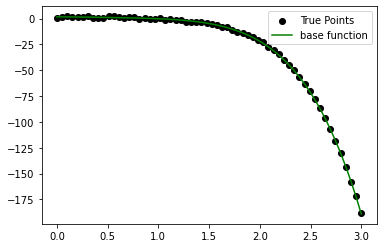

In [6]:

# coding: utf-8

# # Multidimentional Gaussian

# In[4]:


import pymc3 as pm
import theano.tensor as tt
import numpy as np

import matplotlib.pyplot as plt

#%matplotlib inline


# Generate data

# In[30]:


#Define a function
def fxn(x,params):
    return np.polyval(params,x)

#Initialize the parameters to the base value
np.random.seed(123)
params = np.random.normal(loc=0.,scale=1,size=6)

#Create the base function
m = 60
x = np.linspace(0,3,m)
y = (fxn(x,params).flatten() + np.random.normal(loc=0,scale=0.5,size=m))
y_true = fxn(x,params)
     
plt.scatter(x,y,marker='o',color='k',label='True Points')
plt.plot(x,y_true,color='g',label='base function')
plt.legend()
plt.show()





In [2]:
y_true

array([ -1.50629471,  -1.4894701 ,  -1.46834461,  -1.44377458,
        -1.41661634,  -1.38772621,  -1.35796054,  -1.32817564,
        -1.29922785,  -1.27197349,  -1.24726891,  -1.22597041,
        -1.20893435,  -1.19701704,  -1.19107482,  -1.19196401,
        -1.20054095,  -1.21766196,  -1.24418338,  -1.28096154,
        -1.32885276,  -1.38871337,  -1.46139971,  -1.5477681 ,
        -1.64867488,  -1.76497637,  -1.8975289 ,  -2.04718881,
        -2.21481242,  -2.40125606,  -2.60737607,  -2.83402877,
        -3.08207049,  -3.35235756,  -3.64574631,  -3.96309308,
        -4.30525419,  -4.67308597,  -5.06744475,  -5.48918686,
        -5.93916863,  -6.4182464 ,  -6.92727648,  -7.46711521,
        -8.03861893,  -8.64264395,  -9.28004661,  -9.95168325,
       -10.65841018, -11.40108374, -12.18056026, -12.99769606,
       -13.85334749, -14.74837087, -15.68362252, -16.65995878,
       -17.67823597, -18.73931044, -19.8440385 , -20.99327649])

In [4]:
n = 6
a = np.random.normal(loc=params[0],scale=0.1*abs(params[0]),size=n)
b = np.random.normal(loc=params[1],scale=0.1*abs(params[1]),size=n)
c = np.random.normal(loc=params[2],scale=0.1*abs(params[2]),size=n)
d = np.random.normal(loc=params[3],scale=0.1*abs(params[2]),size=n)
X = np.vstack([a,b,c,d]).T

#Define the error function
def error_fxn(params,x,y):
    test = fxn(x,params)
    return sum((y-test)**2.)

#Compute the error
errors = np.array([error_fxn(p,x,y) for p in X])


# Now we create the gaussian process model

# In[63]:
errors

array([ 68.0251292 , 274.19491391, 266.89960302,  56.16500063,
        24.84372529,  21.87540179])

In [ ]:
errors

In [8]:
len(x)

60

In [ ]:

with pm.Model() as surrogate_model:
    ls    = pm.HalfNormal('l',2./3,shape=len(params))
    eta   = pm.HalfNormal('eta',1.0,shape=1)
    cov   = eta**2.*pm.gp.cov.ExpQuad(len(params),ls_inv=ls)
    sigma = pm.HalfNormal('sigma',1.0)

    gp = pm.gp.Marginal(cov_func=cov)

    y_ = gp.marginal_likelihood('y',X=X,y=errors,noise=sigma)
    
    trace = pm.sample(3,tune=1000,njobs=1)


# In[65]:


# with surrogate_model:
#     f_pred = gp.conditional('f_pred',Xnew=X)
    
# with surrogate_model:
#     pred_samples = pm.sample_ppc(trace,vars=[f_pred],samples=2000)

In [31]:
x1 = np.linspace(0, 1, 10)
x2 = np.arange(1, 4)
# Cartesian product
X2 = np.dstack(np.meshgrid(x1, x2)).reshape(-1, 2)
X2

array([[0.        , 1.        ],
       [0.11111111, 1.        ],
       [0.22222222, 1.        ],
       [0.33333333, 1.        ],
       [0.44444444, 1.        ],
       [0.55555556, 1.        ],
       [0.66666667, 1.        ],
       [0.77777778, 1.        ],
       [0.88888889, 1.        ],
       [1.        , 1.        ],
       [0.        , 2.        ],
       [0.11111111, 2.        ],
       [0.22222222, 2.        ],
       [0.33333333, 2.        ],
       [0.44444444, 2.        ],
       [0.55555556, 2.        ],
       [0.66666667, 2.        ],
       [0.77777778, 2.        ],
       [0.88888889, 2.        ],
       [1.        , 2.        ],
       [0.        , 3.        ],
       [0.11111111, 3.        ],
       [0.22222222, 3.        ],
       [0.33333333, 3.        ],
       [0.44444444, 3.        ],
       [0.55555556, 3.        ],
       [0.66666667, 3.        ],
       [0.77777778, 3.        ],
       [0.88888889, 3.        ],
       [1.        , 3.        ]])

In [54]:
x2 = np.array([[1,2,3,4],[4,5,6,7]])
ls = np.array([-1,-1,-1])
cov = pm.gp.cov.ExpQuad(input_dim=1, ls=ls)
np.round(cov(x2).eval(),10)


array([[1.000e+00, 1.371e-06],
       [1.371e-06, 1.000e+00]])

In [50]:
np.shape(x2)

(2, 3)